<a href="https://colab.research.google.com/github/cdiegor/Simulacao/blob/main/Estoque_(s%2CS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Estoque (s,S) — Simulação em SimPy

Este caderno implementa um sistema de estoque em **SimPy**:
- Chegadas de clientes com taxa \(\lambda\) (Poisson) e demandas inteiras com Binomial(n, p).
- Reposição com tempo Exponencial(L).


## Parâmetros

- (s, S) - Estoque crítico e máximo
- $\lambda$ - taxa de chegada
- L - média do tempo de reposição
- K - custo fixo por pedido
- c_ped - custo unitário do pedido
- p_perda - penalidade por unidade perdida
- h - custo manutenção por unidade/tempo


In [5]:
!pip install simpy
import simpy

In [11]:
import numpy as np

# ------------------------------
# Utilidades
# ------------------------------
def make_rng(seed=None):
    return np.random.default_rng(seed)


# Amostrador de lead time (exemplo: Exponencial com média L)
def reposicao_amostra(rng, L):
    return rng.exponential(L)

# ------------------------------
# Modelo (s, S) com perdas
# ------------------------------
class Estoque_sS:
    def __init__(self, env, s, S, taxa_interchegada, L_media,
                 custo_fixo_pedido=100.0, custo_unit_pedido=5.0,
                 custo_perda=1.0, custo_manutencao=0.0,
                 demanda_n=5, demanda_p=0.5,
                 seed=None):
        """
        env: simpy.Environment
        s, S: parâmetros da política (s, S)
        taxa_interchegada: taxa do processo de Poisson para chegadas (lambda), i.e., E[inter] = 1/lambda
        L_media: média do tempo de reposição (usada em reposicao_amostra)
        custos: K (fixo), c (unitário), p (penalidade perda), h (holding por unidade/tempo)
        """
        self.env = env
        self.rng = make_rng(seed)

        # Parâmetros da política
        self.s = float(s)
        self.S = float(S)

        # Chegadas: interchegada ~ Exp(1/lambda)
        self.lambda_chegada = float(taxa_interchegada)
        self.L_media = float(L_media)

        # Custos
        self.custo_fixo_pedido = float(custo_fixo_pedido)
        self.custo_unit_pedido = float(custo_unit_pedido)
        self.custo_perda = float(custo_perda)
        self.custo_manutencao = float(custo_manutencao)

        # Estado
        self.em_maos = self.S         # começa cheio
        self.em_pedido = []           # lista de quantidades pendentes
        self.pedidos = 0              # nº de pedidos emitidos

        # Métricas acumuladoras
        self._last_t = env.now
        self._area_em_maos = 0.0                # integral de em_maos(t)
        self.unidades_perdidas = 0
        self.custo_total = 0.0
        self.atendidas = 0
        self.chegadas = 0
        self.tempo_eventos = []
        self.historico_em_maos = []
        self.historico_total = []

        # Inicia processos
        self.pr_chegadas = env.process(self._processo_chegadas())

    # --------- helpers de estado ---------
    @property
    def total_estoque(self):
        return self.em_maos + sum(self.em_pedido)

    def _atualiza_area(self):
        """Integra em_maos(t) para holding cost e estoque médio."""
        t = self.env.now
        dt = t - self._last_t
        if dt > 0:
            self._area_em_maos += self.em_maos * dt
            # custo de manutenção h acumulado continuamente
            self.custo_total += self.custo_manutencao * self.em_maos * dt
            self._last_t = t

    def _tenta_pedir(self):
        """Aplica a política (s, S) sobre a POSIÇÃO de estoque."""
        estoque = self.total_estoque
        if estoque <= self.s:
            Q = self.S - estoque
            if Q > 0:
                self._emite_pedido(Q)

    def _emite_pedido(self, Q):
        """Cria um pedido de quantidade fixa Q (decidida no gatilho)."""
        self.em_pedido.append(Q)
        self.pedidos += 1
        # custo de pedido (fixo + unitário)
        self.custo_total += self.custo_fixo_pedido + self.custo_unit_pedido * Q
        # agenda entrega após lead time aleatório
        L = reposicao_amostra(self.rng, self.L_media)
        self.env.process(self._entrega(Q, L))

    def _entrega(self, Q, L):
        """Entrega do pedido após lead time L."""
        yield self.env.timeout(L)
        # chegada do pedido
        self._atualiza_area()
        # remove Q da lista em_pedido (uma ocorrência)
        # (em geral não há duas entradas com mesmo Q, mas fazemos seguro)
        for i, q in enumerate(self.em_pedido):
            if np.isclose(q, Q):
                self.em_pedido.pop(i)
                break
        self.em_maos += Q
        self.tempo_eventos.append(self.env.now)
        self.historico_em_maos.append(self.em_maos)
        self.historico_total.append(self.total_estoque)
        # após a entrega, podemos verificar se já precisamos (novamente) pedir
        self._tenta_pedir()

    # --------- processo de chegadas ---------
    def _processo_chegadas(self):
        while True:
            inter = self.rng.exponential(1.0 / self.lambda_chegada)
            yield self.env.timeout(inter)

            self._atualiza_area()
            self.chegadas += 1

            q = self.rng.binomial(demanda_n, demanda_p)
            # perdas
            r = min(self.em_maos, q)
            self.em_maos -= r
            self.atendidas += r
            perdidas = q - r
            if perdidas > 0:
                self.unidades_perdidas += perdidas
                self.custo_total += self.custo_perda * perdidas

            self.tempo_eventos.append(self.env.now)
            self.historico_em_maos.append(self.em_maos)
            self.historico_total.append(self.total_estoque)

            # checar gatilho (s, S) com base na POSIÇÃO
            self._tenta_pedir()

    # --------- coleta de resultados ---------
    def resultados(self, T_total):
        """Retorna dicionário com métricas consolidadas após simular até T_total."""
        estoque_medio = self._area_em_maos / max(T_total, 1e-9)
        taxa_perda = self.unidades_perdidas / max(self.unidades_perdidas + self.atendidas, 1e-9)
        taxa_atendimento = self.atendidas / max(self.atendidas + self.unidades_perdidas, 1e-9)
        custo_medio_tempo = self.custo_total / max(T_total, 1e-9)
        return {
            "em_maos": self.em_maos,
            "em_pedido_total": float(sum(self.em_pedido)),
            "pedidos_emitidos": self.pedidos,
            "chegadas": self.chegadas,
            "atendidas": self.atendidas,
            "perdidas": self.unidades_perdidas,
            "taxa_perda": taxa_perda,            # % das demandas perdidas
            "taxa_atendimento": taxa_atendimento,# Nível de serviço
            "estoque_medio": estoque_medio,
            "custo_total": self.custo_total,
            "custo_medio_por_tempo": custo_medio_tempo,
        }

               em_maos: 200.0
       em_pedido_total: 0.0
      pedidos_emitidos: 9
              chegadas: 2018
             atendidas: 3907.0
              perdidas: 1197.0
            taxa_perda: 0.2345219435736677
      taxa_atendimento: 0.7654780564263323
         estoque_medio: 177.16823469380242
           custo_total: 9311.0
 custo_medio_por_tempo: 93.11


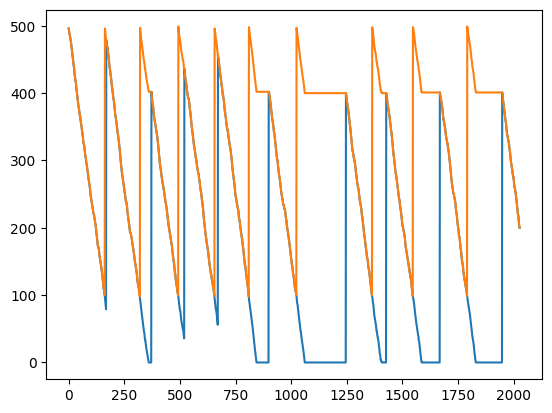

In [7]:

import matplotlib.pyplot as plt

# Parâmetros
s, S = 100, 500
lambda_chegada = 20.0      # taxa (E[inter] = 1/20)
L_media = 5.0              # média do lead time

K = 100.0                  # custo fixo por pedido
c_ped = 2.0                # custo unitário do pedido
p_perda = 1.0              # penalidade por unidade perdida
h = 0.0                    # custo manutenção por unidade/tempo

T_total = 100.0
seed = 2025

env = simpy.Environment()
modelo = Estoque_sS(env, s, S, lambda_chegada, L_media,
                    custo_fixo_pedido=K,
                    custo_unit_pedido=c_ped,
                    custo_perda=p_perda,
                    custo_manutencao=h,
                    seed=seed)
env.run(until=T_total)

res = modelo.resultados(T_total)
for k, v in res.items():
    print(f"{k:>22s}: {v}")

plt.plot(modelo.historico_em_maos, label="em_maos")
plt.plot(modelo.historico_total, label="total")

In [14]:
def executar_simulacao(s, S, lambda_chegada, L_media, K, c_ped, p_perda, h, demanda_n, demanda_p, T_total, seed=None):
    """
    Executa uma simulação do sistema de estoque (s, S) e retorna os resultados.

    Parâmetros:
    s, S: parâmetros da política (s, S)
    lambda_chegada: taxa do processo de Poisson para chegadas (lambda)
    L_media: média do tempo de reposição
    K: custo fixo por pedido
    c_ped: custo unitário do pedido
    p_perda: penalidade por unidade perdida
    h: custo manutenção por unidade/tempo
    T_total: tempo total da simulação
    seed: semente para o gerador de números aleatórios
    demanda_n, demanda_p: parâmetros para a distribuição binomial da demanda

    Retorna:
    Um dicionário com as métricas consolidadas da simulação.
    """
    env = simpy.Environment()
    modelo = Estoque_sS(env, s, S, lambda_chegada, L_media,
                        custo_fixo_pedido=K,
                        custo_unit_pedido=c_ped,
                        custo_perda=p_perda,
                        custo_manutencao=h,
                        demanda_n=demanda_n,
                        demanda_p=demanda_p,
                        seed=seed)
    env.run(until=T_total)

    res = modelo.resultados(T_total)
    return res


In [15]:
from math import sqrt
from scipy.stats import t as student_t

def executar_replicas(s, S, lambda_chegada, L_media, K, c_ped, p_perda, h,  demanda_n, demanda_p, T_total=1000, seed=None, R=30):
    rng = make_rng(seed)
    ys = []
    for r in range(R):
        seed = int(rng.integers(0, 2**63-1))
        res = executar_simulacao(s, S, lambda_chegada, L_media, K, c_ped, p_perda, h,  demanda_n, demanda_p, T_total, seed)
        ys.append(res["custo_total"])
    y = np.array(ys, dtype=float)
    m = float(np.nanmean(y))
    s = float(np.nanstd(y, ddof=1))
    half = student_t.ppf(0.975, R-1) * s / sqrt(R) if R>1 else float("nan")
    return {"R": R, "mean": m, "sd": s, "halfwidth95": half, "samples": y}

In [25]:
# Parâmetros

rep = executar_replicas(s=100, S=500, lambda_chegada=20.0, L_media=5.0,
                        K=100.0, c_ped=2.0, p_perda=1.0, h=0.0,
                        demanda_n=5, demanda_p=0.5,
                        T_total=100.0, seed=2025, R=1000)
print(f"{rep['mean']:>8.3f}  ± {rep['halfwidth95']:>6.3f} (sd={rep['sd']})")

9189.097  ± 41.124 (sd=662.7032889915669)
